# Install required packages and dependencies

In [ ]:
!apt-get install python-opengl -y

!apt install xvfb -y

!pip install pyvirtualdisplay

!pip install piglet
!pip install  -U colabgymrender
!pip install gymnasium

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,815 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxkbfile1 amd64 1:1

# Import Libraries

**gym:** Library for the OpenAI Gym environment, used for creating and interacting with the FrozenLake environment.  

**numpy:** Library for numerical operations, used here for handling the Q-table and arrays.

**time:** Library for measuring the duration of training.

In [ ]:
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython import display

# Initialize the Environment

To begin, we need to create an instance of the FrozenLake environment. This is done using the gym.make function with specific parameters to configure the environment.

- **gym.make('FrozenLake-v1'):** Creates an instance of the FrozenLake environment. This environment is a classic grid-world problem where the agent needs to navigate from a start state to a goal state while avoiding holes.

- **is_slippery=True:** Ensures the environment has its default slippery property, which introduces some randomness into the movement of the agent. This makes the environment more challenging and realistic by simulating slippery surfaces.

- **render_mode='rgb_array':** return the current frame as a NumPy array in RGB format. This array represents the image of the environment, where each pixel is described by three values corresponding to the Red, Green, and Blue color channels.

These settings help in setting up the environment to be used for training the Q-learning agent.

In [ ]:
env = gym.make('FrozenLake-v1', is_slippery=True, render_mode='rgb_array')
env.reset()

(0, {'prob': 1})

# Visualize Environment

(-0.5, 255.5, 255.5, -0.5)

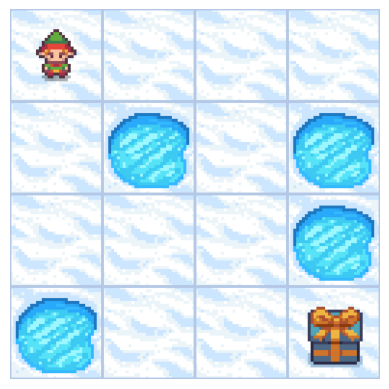

In [ ]:
plt.imshow(env.render())
plt.axis("off")

# Set Hyperparameters

To configure the Q-learning algorithm, we need to define several key parameters. Each parameter plays a crucial role in how the agent learns and interacts with the environment:

- **num_episodes:** Total number of episodes for training the agent. Each episode represents a single run from start to goal (or failure). A higher number of episodes generally leads to better learning as the agent has more opportunities to explore and learn.

- **max_steps_per_episode:** Maximum number of steps allowed in each episode. This limits the number of actions the agent can take before the episode ends, ensuring that it doesn’t run indefinitely.

- **learning_rate:** Rate at which the agent updates its Q-values. A higher learning rate means that the agent places more weight on recent experiences, while a lower learning rate means it considers past experiences more heavily.

- **discount_factor:** Determines how much future rewards are valued compared to immediate rewards. A discount factor close to 1.0 places more value on future rewards, encouraging long-term planning, while a factor close to 0.0 makes the agent focus more on immediate rewards.

- **epsilon:** Exploration rate; the probability of choosing a random action instead of the action with the highest Q-value. This parameter controls the trade-off between exploration (trying new actions) and exploitation (choosing the best-known action).

- **epsilon_decay:** Rate at which epsilon decreases over time. As the agent learns, it should explore less and exploit more. The decay rate determines how quickly the exploration rate decreases.

- **min_epsilon:** Minimum value of epsilon to ensure that some level of exploration is always maintained. This prevents the agent from becoming too greedy and ensures it continues to explore the environment even after extensive training.

These parameters help in fine-tuning the learning process and balancing between exploring new actions and exploiting known strategies.

In [ ]:
num_episodes = 8000  # Increase number of episodes for better learning
max_steps_per_episode = 100
learning_rate = 0.5  # Increase learning rate for faster learning
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.999  # Slower decay rate for more exploration
min_epsilon = 0.01

# Initialize the Q-table

**Q:** A table where rows represent states and columns represent actions. Initialized with zeros, this table will be updated during training.

In [ ]:
Q = np.zeros([env.observation_space.n, env.action_space.n])
print(Q.shape)

(16, 4)


# Define Action Selection Function

The choose_action(state) function is used to select an action based on the current state of the agent. This function utilizes an epsilon-greedy strategy to balance exploration and exploitation.

- **choose_action(state):** Function to select an action based on the current state.
  - **Exploration:** If a random number is less than epsilon, a random action is chosen. This allows the agent to explore different actions and discover new strategies.
  - **Exploitation:** Otherwise, the action with the highest Q-value for the current state is selected. This leverages the knowledge the agent has gained to maximize rewards based on past experiences.
  
This approach helps the agent to not only exploit known strategies but also to explore new possibilities, which is essential for effective learning in reinforcement learning.

In [ ]:
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()  # Explore
    else:
        return np.argmax(Q[state, :])  # Exploit

# Train the Agent


The training loop is responsible for iterating through each episode and updating the Q-values based on the agent's interactions with the environment. Here’s a detailed breakdown:

**For episode in range(num_episodes):** Loop through each episode.

- **state = env.reset()[0]:** Reset the environment to get the initial state.
- **total_reward:** Initialize to track the cumulative reward in the episode.
- **done:** Flag indicating whether the episode has ended.

**Inner Loop (Steps in the Episode)**

- **action = choose_action(state):** Choose an action based on the current state.
- **next_state, reward, done, _ = env.step(action):** Execute the action and observe the result.

**Q-learning Update:**

- **best_next_action:** Get the action with the highest Q-value for the next state.

- **Q[state, action]:** Update the Q-value using the Q-learning formula.

- **state = next_state:** Move to the next state.

- **total_reward += reward:** Accumulate the reward.

- **if done: break:** Exit the loop if the episode ends.

In [ ]:
start_time = time.time()
episode_rewards= []
for episode in range(num_episodes):
    state = env.reset()[0]  # Get the state from the tuple
    total_reward = 0
    done = False

    for step in range(max_steps_per_episode):
        action = choose_action(state)
        next_state, reward, done, _, _ = env.step(action)

        # Q-learning update
        best_next_action = np.argmax(Q[next_state, :])
        Q[state, action] += learning_rate * (reward + discount_factor * Q[next_state, best_next_action] - Q[state, action])

        state = next_state
        total_reward += reward

        if done:
            break

    episode_rewards.append(total_reward)

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Print progress every 500 episodes
    if episode % 500 == 0:
        print(f"Episode {episode}/{num_episodes} - Epsilon: {epsilon:.3f}, Reward: {total_reward}")
end_time = time.time()
print(f"Training complete in {end_time - start_time:.2f} seconds.\n")

Episode 0/8000 - Epsilon: 0.999, Reward: 0.0
Episode 500/8000 - Epsilon: 0.606, Reward: 0.0
Episode 1000/8000 - Epsilon: 0.367, Reward: 0.0
Episode 1500/8000 - Epsilon: 0.223, Reward: 0.0
Episode 2000/8000 - Epsilon: 0.135, Reward: 0.0
Episode 2500/8000 - Epsilon: 0.082, Reward: 0.0
Episode 3000/8000 - Epsilon: 0.050, Reward: 1.0
Episode 3500/8000 - Epsilon: 0.030, Reward: 0.0
Episode 4000/8000 - Epsilon: 0.018, Reward: 0.0
Episode 4500/8000 - Epsilon: 0.011, Reward: 0.0
Episode 5000/8000 - Epsilon: 0.010, Reward: 1.0
Episode 5500/8000 - Epsilon: 0.010, Reward: 1.0
Episode 6000/8000 - Epsilon: 0.010, Reward: 0.0
Episode 6500/8000 - Epsilon: 0.010, Reward: 0.0
Episode 7000/8000 - Epsilon: 0.010, Reward: 1.0
Episode 7500/8000 - Epsilon: 0.010, Reward: 1.0
Training complete in 7.95 seconds.



# Plot Average Rewards

Plot the average reward per episode to visualize the learning progress.

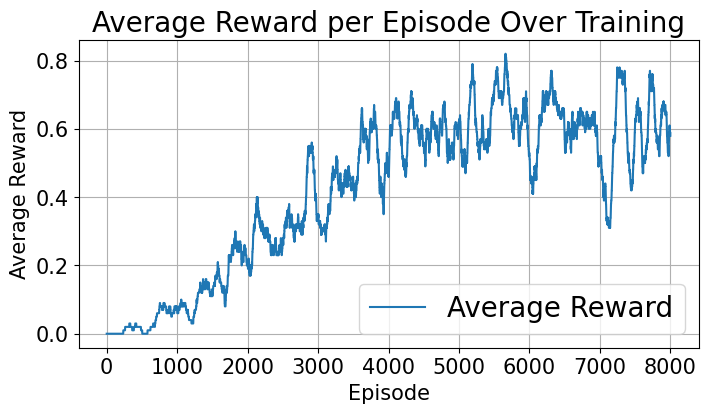

In [ ]:
# Calculate average rewards over 100-episode windows
window_size = 100
average_rewards = [np.mean(episode_rewards[i-window_size:i]) if i >= window_size else np.mean(episode_rewards[:i+1]) for i in range(num_episodes)]

# Plot the average rewards
plt.figure(figsize=(8, 4))
plt.plot(average_rewards, label='Average Reward')
plt.xlabel('Episode', size=15)
plt.ylabel('Average Reward', size=15)
plt.title('Average Reward per Episode Over Training', size=20)
plt.legend(fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

# Use the learned Q-table to navigate the Frozen World Environment
After training, we can use the learned Q-table to navigate the environment and visualize the agent's performance. Here’s a step-by-step breakdown:

- **state = env.reset()[0]:** Reset the environment to get the initial state.
- **while not done:** Loop until the episode ends.
  - **action = np.argmax(Q[state, :]):** Choose the action with the highest Q-value for the current state.
  - **state, reward, done, _ = env.step(action):** Execute the action and transition to the next state.
  - **env.render():** Render the environment to visualize the agent’s actions in real-time.
  - **if done: break:** Exit the loop if the episode ends (when the agent reaches the goal or falls into a hole).  
  
This section allows you to observe how well the agent performs with the learned Q-values by rendering the environment and showing the agent's path to the goal or encountering any obstacles.

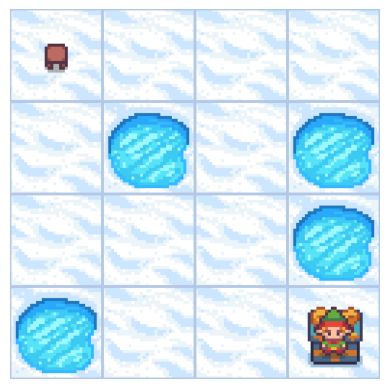

In [ ]:
from pyvirtualdisplay import Display
Display().start()

state = env.reset()[0]  # Get the state from the tuple
done = False
img = plt.imshow(env.render()) # only call this once
plt.axis('off')
while not done:
    action = np.argmax(Q[state, :])
    state, reward, done, _, _ = env.step(action)
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.2)
env.close()